Common definitions

In [1]:
import sys
sys.path.append( '..' )

from enum import IntEnum
class FRAME_SIZE_E(IntEnum):
    SMALL = 1
    TYPICAL = 2
    WIDE = 3
    TALL = 4
    LARGE = 5
    NUM_FRAMES_SIZES = 6


Vanilla Python Class example

In [2]:
class MyPythonParams():
    #Constructor
    def __init__(self, FRAME_COUNT=5, 
                       FRAME_WIDTH=640, 
                       FRAME_HEIGHT=480, 
                       MEM_REGIONS=None,
                       FRAME_SIZE="SMALL"):
        self.FRAME_COUNT = FRAME_COUNT
        self.FRAME_WIDTH = FRAME_WIDTH
        self.FRAME_HEIGHT = FRAME_HEIGHT
        #Convert string to enum type
        self.FRAME_SIZE = FRAME_SIZE_E[FRAME_SIZE]
        #Mutatble defaults, such as lists, have to be handled carefully
        self.MEM_REGIONS = MEM_REGIONS if MEM_REGIONS is not None else ["RAM"]

    #string class representation
    def __repr__(self):
        return f"pythonParams - " + \
                f"FRAME_COUNT: {self.FRAME_COUNT}, " + \
                f"FRAME_WIDTH: {self.FRAME_WIDTH}, " + \
                f"FRAME_HEIGHT: {self.FRAME_HEIGHT}, " + \
                f"FRAME_SIZE: {self.FRAME_SIZE.name}, " + \
                f"MEM_REGIONS: {self.MEM_REGIONS}"

In [3]:
params = MyPythonParams(FRAME_WIDTH=200, FRAME_SIZE="LARGE")
print(params)

pythonParams - FRAME_COUNT: 5, FRAME_WIDTH: 200, FRAME_HEIGHT: 480, FRAME_SIZE: LARGE, MEM_REGIONS: ['RAM']


dataclasses class example

No more manually creating \_\_init\_\_ and \_\_repr\_\_ functions

\_\_post_init\_\_ is used to add custom \_\_init\_\_ behavior

In [4]:
from dataclasses import dataclass, field

@dataclass
class MyDataclassesParams:
    FRAME_COUNT  : int = field(default=5)
    FRAME_WIDTH  : int = 640 # dataclass implies field(default=val)
    FRAME_HEIGHT : int = field(default=480)
    FRAME_SIZE   : FRAME_SIZE_E = field(default="SMALL")
    #dataclasses handles mutatable defaults cleaner with factory functions
    MEM_REGIONS  : list = field(default_factory=lambda:["RAM"])
    
    def __post_init__(self):
      #Still need to convert that string input to an enum
      self.FRAME_SIZE = FRAME_SIZE_E[self.FRAME_SIZE]

In [5]:
params = MyDataclassesParams(FRAME_WIDTH=200, FRAME_SIZE="LARGE")
print(params)

MyDataclassesParams(FRAME_COUNT=5, FRAME_WIDTH=200, FRAME_HEIGHT=480, FRAME_SIZE=<FRAME_SIZE_E.LARGE: 5>, MEM_REGIONS=['RAM'])


DatagenDV class example

In [6]:
import datagenDV as dg
from dataclasses import dataclass

@dataclass
class MyDatagenParams(dg.ParamsBase):
    FRAME_COUNT  : int = dg.field(5)
    FRAME_WIDTH  : int = dg.field(640)
    FRAME_HEIGHT : int = dg.field(480)
    FRAME_SIZE   : FRAME_SIZE_E = dg.field("SMALL")
    MEM_REGIONS  : list = dg.field(lambda:["RAM"])
    
    
    
    

In [7]:
params = MyDatagenParams(FRAME_WIDTH=200, FRAME_SIZE="LARGE")
print(params)

MyDatagenParams(FRAME_COUNT=5, FRAME_WIDTH=200, FRAME_HEIGHT=480, FRAME_SIZE=<FRAME_SIZE_E.LARGE: 5>, MEM_REGIONS=['RAM'])


datagenDV also provides runtime warnings for bad types.

In [8]:
try:
    params = MyDatagenParams(FRAME_WIDTH="Not an integer")
except Exception as e:
    print(e)

<class '__main__.MyDatagenParams'> : Expected FRAME_WIDTH to be <class 'int'>, got <class 'str'>


YAML input/output

In [9]:
@dataclass
class MyDatagenYMLParams(dg.YAMLParamsBase):
    #YAML fields
    FRAME_COUNT  : int   = dg.field(5, dir='in_out')
    FRAME_WIDTH  : int   = dg.field(640, dir='in_out')
    FRAME_HEIGHT : int   = dg.field(480, dir='in_out')
    MEM_REGIONS  : list  = dg.field(lambda:["RAM"], dir='in')
    FRAME_SIZE   : FRAME_SIZE_E  = dg.field("SMALL", dir='in_out')
    ADDRESS : int = dg.field(None, dir='out')
    
    

In [10]:
input_yaml = """
param_example: !DatagenParams
    FRAME_COUNT: 3
    FRAME_HEIGHT: 320
    MEM_REGIONS: 
        - ROM
        - RAM 
    FRAME_SIZE : LARGE
"""

In [11]:
import sys
#Setup
from ruamel.yaml import YAML
yaml = YAML()
yaml.register_class(MyDatagenYMLParams)
#Load
data = yaml.load(input_yaml)
#Modify
data['param_example'].ADDRESS = 1234
#Dump
yaml.dump(data, sys.stdout)


yaml.dump(data, sys.stdout, transform=lambda s: s.replace('!', ''))




#FIXME - figure out the best way to allow !class name on dump optionally

param_example: !DatagenParams
  FRAME_COUNT: 3
  FRAME_HEIGHT: 320
  MEM_REGIONS:
  - ROM
  - RAM
  FRAME_SIZE: LARGE
param_example: DatagenParams
  FRAME_COUNT: 3
  FRAME_HEIGHT: 320
  MEM_REGIONS:
  - ROM
  - RAM
  FRAME_SIZE: LARGE


In [12]:
"""
param_example: 
  FRAME_COUNT: 3
  FRAME_WIDTH: 640
  FRAME_HEIGHT: 320
  FRAME_SIZE: LARGE
  ADDRESS: 1234
"""

'\nparam_example: \n  FRAME_COUNT: 3\n  FRAME_WIDTH: 640\n  FRAME_HEIGHT: 320\n  FRAME_SIZE: LARGE\n  ADDRESS: 1234\n'

PyVSC Constrained Randomization

PyVSC standard implementation

In [13]:
import vsc
@vsc.randobj
class FrameParams():
    def __init__(self):
        self.FRAME_SIZE = vsc.rand_bit_t(64)
        self.FRAME_WIDTH = vsc.rand_bit_t(32)
        self.FRAME_HEIGHT = vsc.rand_bit_t(32)
        
    @vsc.constraint
    def frame_dimensions_c(self):
        self.FRAME_SIZE == self.FRAME_WIDTH * self.FRAME_HEIGHT

Datagen PyVSC implementation

In [14]:
import vsc
@dg.rand_dataclass
class FrameParams(dg.YAMLParamsBase):
    FRAME_SIZE : int = dg.rand_field(vsc.rand_bit_t, 64)
    FRAME_WIDTH  : int = dg.rand_field(vsc.rand_bit_t, 32)
    FRAME_HEIGHT : int = dg.rand_field(vsc.rand_bit_t, 32)


In [15]:
inst = FrameParams()
inst.randomize()
print(inst)

FrameParams(FRAME_SIZE=14551216839445579389, FRAME_WIDTH=427695337, FRAME_HEIGHT=2373505163)


Add some constraints

In [16]:
@dg.rand_dataclass
class FrameParams(dg.YAMLParamsBase):
    FRAME_SIZE   : int = dg.rand_field(vsc.rand_bit_t, 64)
    FRAME_WIDTH  : int = dg.rand_field(vsc.rand_bit_t, 32)
    FRAME_HEIGHT : int = dg.rand_field(vsc.rand_bit_t, 32)
    
    @vsc.constraint
    def frame_dimensions_c(self):
        self.rand_FRAME_SIZE == self.rand_FRAME_WIDTH * self.rand_FRAME_HEIGHT

    @vsc.constraint
    def sizes_c(self):
        self.rand_FRAME_SIZE.inside(vsc.rangelist((16, 65536)))
        self.rand_FRAME_WIDTH.inside(vsc.rangelist((4, 256)))
        self.rand_FRAME_HEIGHT.inside(vsc.rangelist((4, 256)))


In [17]:
inst = FrameParams()
inst.randomize()
print(inst)

FrameParams(FRAME_SIZE=15563, FRAME_WIDTH=197, FRAME_HEIGHT=79)


In [18]:
inst = FrameParams(FRAME_WIDTH=100)
inst.randomize()
print(inst)

FrameParams(FRAME_SIZE=22200, FRAME_WIDTH=100, FRAME_HEIGHT=222)


What if you want to check your random distribution? Python makes it easy with matplotlib


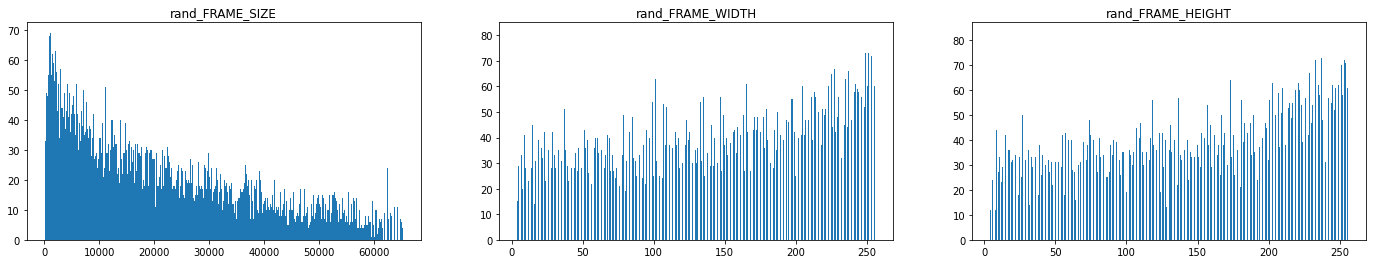

In [19]:
import matplotlib.pyplot as plt
def randomize_and_graph_histograms(rand_class, N=10000):
    class_inst = rand_class()
    var_list = {}
    #Randomize N times, collecting values for graphing
    for i in range(0,N):
        class_inst.randomize()
        class_inst_vars =  vars(class_inst)
        for v in class_inst_vars:
            if v.startswith("rand"):
                var_list.setdefault(v, []).append(class_inst_vars[v].get_val())
  
    fig, axs = plt.subplots(1,len(var_list)) 
    for i,k in enumerate(var_list.keys()):
        axs[i].hist(var_list[k], bins=500)
        axs[i].set_title(k)

    fig.set_size_inches(24, 4)
    fig.show()
      
#Call our generic function with FrameParams and randomize it 10000 times  
randomize_and_graph_histograms(FrameParams, N=10000)

Ctypes binary creation and loading